Week 3: Global Optimization

4.2 The potential

In [39]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rc('animation', html='jshtml')  # For Jupyter notebooks

In [40]:
#N = 50  # number of points
highlighted_dots = 5
Delta = 1  # magnitude of step size
steps = 100  # number of iterations in walk
kT = 1.0  # Temperature for the Metropolis criterion

In [41]:
#defining the potential
def V(x):
    return (-1  -np.exp(-((x+15)/10)**2) \
              -2*np.exp(-((x-10)/10)**2) + \
                -np.exp(-((x-35)/10)**2) \
              -3*np.exp(-((x-60)/10)**2) \
                -np.exp(-((x-85)/10)**2)\
              -2*np.exp(-((x-110)/10)**2) \
              ) * \
            (1+1/5*np.cos(2*np.pi/2.5*x))

<function matplotlib.pyplot.show(close=None, block=None)>

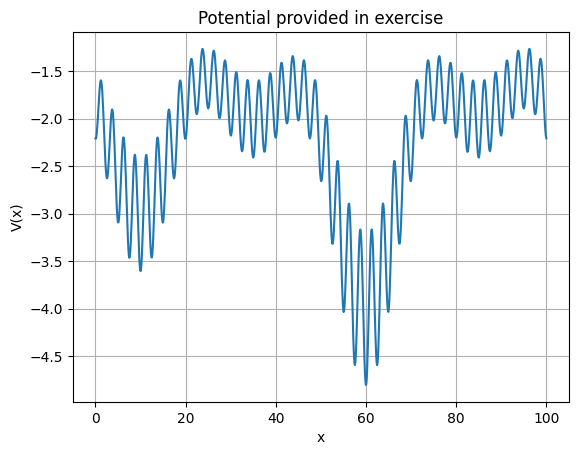

In [42]:
#plotting the potential
x = np.linspace (0,100,1000)
y = V(x)

plt.plot(x,y, label='V(x)')
plt.title('Potential provided in exercise')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.legend
plt.grid(True)
plt.show

4.3 Short trajectories: Metropolis MC to create a Markov chain trajectory at two different temps.

In [43]:
#metropolis sampling function specifically for the given potential in the exercise
print(V(x))
def metropolis_sampling(x0, N, Delta,kT):
    samples = []
    current_x = x0
    for _ in range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)

    return np.array(samples)


[-2.20939547 -2.21174038 -2.1914553  -2.15027332 -2.09128153 -2.01874491
 -1.93785365 -1.85440869 -1.77446425 -1.70394927 -1.64829106 -1.61206516
 -1.59869366 -1.61021181 -1.64711877 -1.7083232  -1.79118855 -1.89167692
 -2.0045837  -2.12384981 -2.24293275 -2.35521403 -2.4544176  -2.53501291
 -2.59257674 -2.62409016 -2.62815069 -2.60508484 -2.55695231 -2.48743983
 -2.40164987 -2.30579587 -2.20682214 -2.11197152 -2.02832765 -1.96236071
 -1.9195057  -1.90380079 -1.91760977 -1.96144752 -2.03392131 -2.13179321
 -2.25016145 -2.38275069 -2.52229422 -2.6609846  -2.79096505 -2.90483031
 -2.99610506 -3.05966889 -3.09209971 -3.09191257 -3.0596772  -2.99800513
 -2.91140578 -2.80601906 -2.68924028 -2.56926032 -2.4545496  -2.35331853
 -2.27298887 -2.21971027 -2.19795343 -2.2102071  -2.25679936 -2.33585591
 -2.44339951 -2.57358536 -2.71905855 -2.87141165 -3.02171376 -3.1610776
 -3.28122823 -3.37503691 -3.43698538 -3.46352991 -3.45334118 -3.40740352
 -3.32896609 -3.22334836 -3.09761141 -2.96011542 -2.

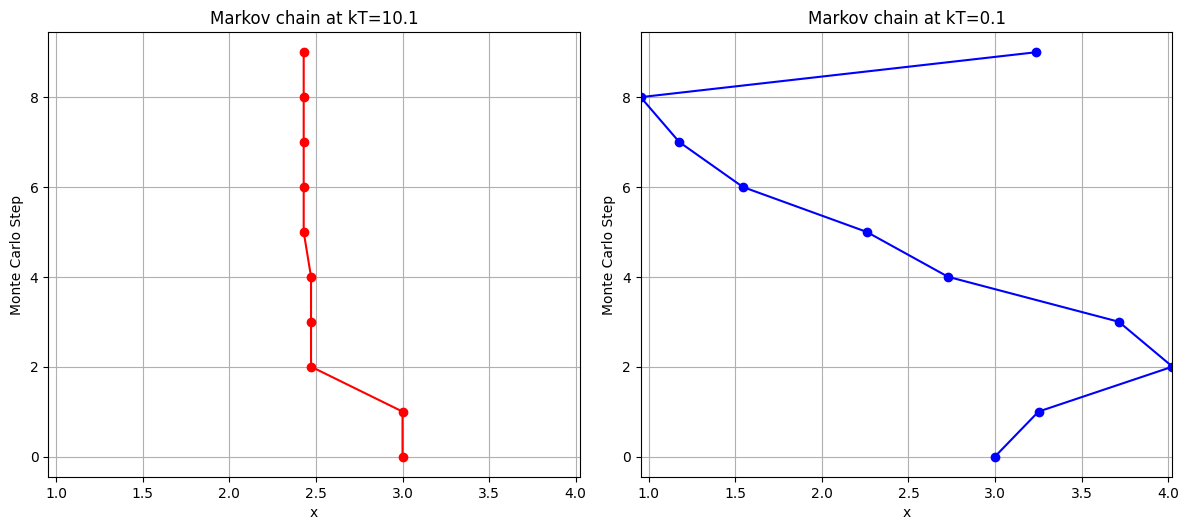

In [67]:
MC_time_interval = 9
delta = 1
starting_x = 3

# First plot: kT=10.10
kT_1 = 10.10
chain_1 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_1)
chain_1 = np.insert(chain_1, 0, starting_x)
MC_steps_1 = np.arange(MC_time_interval + 1)

# Second plot: kT=1
kT_2 = 0.1
chain_2 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_2)
chain_2 = np.insert(chain_2, 0, starting_x)
MC_steps_2 = np.arange(MC_time_interval + 1)

x_limits = (min(min(chain_1), min(chain_2)), max(max(chain_1), max(chain_2)))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(chain_2, MC_steps_2, marker='o', linestyle='-', color='r')
axs[0, 0].set_title(f'Markov chain at kT={kT_1}')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Monte Carlo Step')
axs[0, 0].set_xlim(x_limits)
axs[0, 0].grid(True)

axs[0, 1].plot(chain_1, MC_steps_1, marker='o', linestyle='-', color='b')
axs[0, 1].set_title(f'Markov chain at kT={kT_2}')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Monte Carlo Step')
axs[0, 1].set_xlim(x_limits)
axs[0, 1].grid(True)

axs[1, 0].set_visible(False)
axs[1, 1].set_visible(False)


plt.tight_layout()
plt.show()